In [1]:
import sys, os

#Our project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), os.pardir))
sys.path.append(PROJECT_ROOT)

#Local packages loaded from src specifying useful constants, and our custom loader
from util.constants import DATA_PATHS
from util.dataset import OcelotDatasetLoader, torch_to_image, seg_mask_from_dataloader
from util.unet import Unet

#other modules of interest
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as transf
from PIL import Image
import numpy as np

In [2]:
my_device = torch.device(device = 'cuda' if torch.cuda.is_available() else 'cpu')
pin_memory = True if my_device == 'cuda' else False
d_type_f32 = torch.float32
batch_size = 128
transforms = transf.Compose([transf.ToTensor()])

In [3]:
#Load our data in our special dataloader
TissTrainData = OcelotDatasetLoader(paths = DATA_PATHS, dataToLoad = 'Tissue', transforms=transforms)

#Establish a train/validation split size
TrainValSplit = [int(0.8*len(TissTrainData)), len(TissTrainData) - int(0.8*len(TissTrainData))]

#Establish our training and validation data using torch's built in random_split on our own formatted data
TrainingData, ValidationData = torch.utils.data.random_split(TissTrainData, TrainValSplit)

In [4]:
#Load into Pytorch's built in DataLoader
TissTrainLoader = DataLoader(TissTrainData, batch_size=batch_size, num_workers=4) #SWAP TO TissTrainData FOR FULL DATASET
TissValLoader = DataLoader(ValidationData, batch_size=batch_size, num_workers=4)

In [5]:
learning_rate= 1e-3
weight_decay = 1e-3
nepochs = 10
criterion = torch.nn.BCEWithLogitsLoss()
#optimizer_sgd = torch.optim.SGD(params=..., lr=learning_rate, momentum=0.9, weight_decay=weight_decay) #TODO

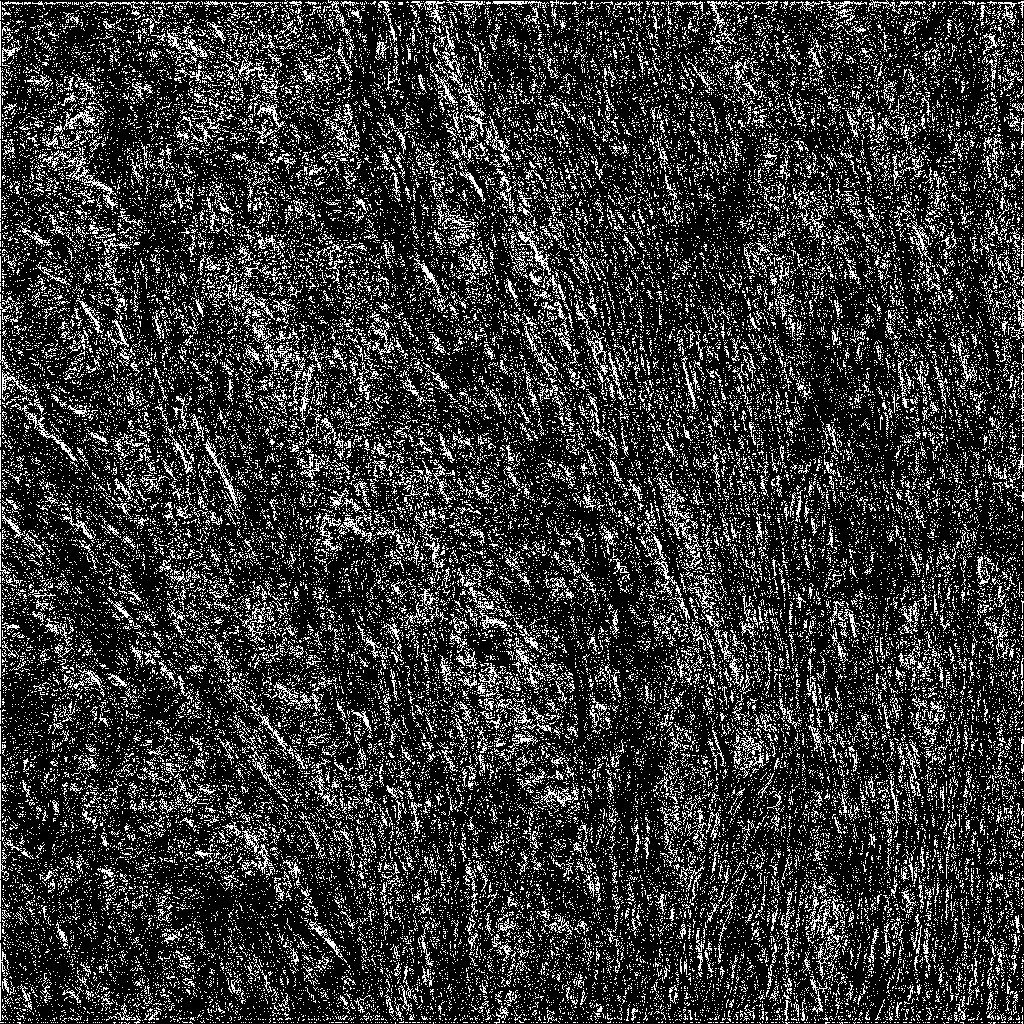

In [8]:
#Now let's see take some subset of our original data from data loader and see what our tissue mask looks like before training!
indices =  [0]
subset = torch.utils.data.Subset(TrainingData, indices)
MaskTestData = DataLoader(dataset = subset, batch_size=batch_size, num_workers=4)

#First we need to specify some info on our model: we have 3 channels RGB, 2 class: tissue, not tissue
model = Unet(n_channels=3, n_classes=2)
untrained_sample_masks = seg_mask_from_dataloader(model, MaskTestData, d_type_f32, my_device)
torch_to_image(untrained_sample_masks[0])